In [0]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.stats import kurtosis 
from sklearn.decomposition import FastICA

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, adjusted_mutual_info_score as ami

In [0]:
random_seed = 1
wine = 'winequality-white.csv'
df = df = pd.read_csv(wine, sep=';')
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]
# Standardize
X_std = StandardScaler().fit_transform(X)
X_std = pd.DataFrame(data=X_std, columns=X.columns)
# X, X_test, Y, Y_test = train_test_split(data_X, data_y, train_size=0.8, random_state=random_seed)

# ICA

In [0]:
def ica(X, Y, random_seed, no_features, ds_name):
  kurt = []
  fit_time = []
  # max components = no features
  comp = range(1, no_features+3)
  
  for i in comp:
    ica = FastICA(n_components=i, random_state=random_seed)
    start = datetime.datetime.now()
    ica.fit(X)
    finish = datetime.datetime.now()
    fit_time.append((finish - start).total_seconds())
    # Get the PCs into X
    # X = pca.transform(X)
    kurt.append(np.average(kurtosis(ica.components_, fisher=False)))
  
  # Plot ICA
  plt.plot(comp,kurt, marker='o')
  plt.title('ICA - ' + ds_name)
  plt.xlabel('Number of components')
  plt.ylabel('Kurtosis')
  plt.legend(loc='best')
  plt.grid()
  plt.show()

  print('Independent components - Fit times')
  print(*comp)
  print(fit_time)

# Clustering code

In [0]:
from sklearn.metrics import v_measure_score
def kmeans(X, Y, random_seed, ds_name):
  wcss = []
  homo = []
  comp = []
  ami_score = []
  sil_score = []
  v_score = []
  fit_time = []
  # we know no labels = 7
  k_vals = range(2, 11)
  for i in k_vals:
      kmeans = KMeans(n_clusters=i, init='k-means++', random_state=random_seed)
      start = datetime.datetime.now()
      kmeans.fit(X)
      finish = datetime.datetime.now()
      fit_time.append((finish - start).total_seconds())
      labels_pred = kmeans.labels_
      wcss.append(kmeans.inertia_)
      sil_score.append(silhouette_score(X, labels_pred , metric='euclidean'))
      ami_score.append(ami(Y, labels_pred))
      homo.append(homogeneity_score(Y, labels_pred))
      comp.append(completeness_score(Y, labels_pred))
      v_score.append(v_measure_score(Y, labels_pred))

  # Plot Elbow
  plt.plot(k_vals,wcss, marker='o')
  plt.title('K means - Elbow Method - ' + ds_name)
  plt.xlabel('Number of clusters')
  plt.ylabel('WCSS')
  plt.grid()
  plt.show()

  # Scores
  # plt.plot(k_vals, sil_score, label='Silhoutte score')
  plt.plot(k_vals,ami_score, label='Adj Mutual Info', marker='o')
  plt.plot(k_vals,homo, label='Homogeneity', marker='o')
  plt.plot(k_vals,comp, label='Completeness', marker='o')
  plt.plot(k_vals,v_score, label='V-measure', marker='o')
  #TODO: Plot time as well
  plt.title('K means - Evaluation Scores - ' + ds_name)
  plt.xlabel('Number of clusters')
  plt.ylabel('Score')
  plt.legend(loc='best')
  plt.show()

def em(X, Y, random_seed, ds_name):
  bic = []
  homo = []
  comp = []
  ami_score = []
  sil_score = []
  v_score = []
  fit_time = []
  # we know no labels = 7
  k_vals = range(2, 11)
  for i in k_vals:
      gmm = GMM(n_components=i, random_state=random_seed)
      start = datetime.datetime.now()
      gmm.fit(X)
      finish = datetime.datetime.now()
      fit_time.append((finish - start).total_seconds())
      #BIC score (lower better)
      bic.append(gmm.bic(X))
      labels_pred = gmm.predict(X)
      sil_score.append(silhouette_score(X, labels_pred , metric='euclidean'))
      ami_score.append(ami(Y, labels_pred))
      homo.append(homogeneity_score(Y, labels_pred))
      comp.append(completeness_score(Y, labels_pred))
      v_score.append(v_measure_score(Y, labels_pred))

  # Plot Elbow
  plt.plot(k_vals,bic, marker='o')
  plt.title('EM - BIC to choose optimal components - ' + ds_name)
  plt.xlabel('Number of components')
  plt.ylabel('BIC')
  plt.grid()
  plt.show()

  # Scores
  # plt.plot(k_vals, sil_score, label='Silhoutte score')
  plt.plot(k_vals,ami_score, label='Adj Mutual Info', marker='o')
  plt.plot(k_vals,homo, label='Homogeneity', marker='o')
  plt.plot(k_vals,comp, label='Completeness', marker='o')
  plt.plot(k_vals,v_score, label='V-measure', marker='o')
  #TODO: Plot time as well
  plt.title('EM - Evaluation Scores - ' + ds_name)
  plt.xlabel('Number of components')
  plt.ylabel('Score')
  plt.legend(loc='best')
  plt.show()


# Neural Networks Code

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
def NN(X, Y, plt_title, random_seed=1):
    # Hyperparameter tuning, hidden layer size
    X_train, X_val_test, y_train, y_val_test = \
        train_test_split(X, Y, train_size=0.8, random_state=random_seed)
    hidden_layer_sizes = [2, 4, 6, 8, 10]
    train_score = []
    test_score = []
    for i in hidden_layer_sizes:
        mlp_model = MLPClassifier(hidden_layer_sizes=(i,),random_state=random_seed)
        mlp_model.fit(X=X_train, y=y_train)
        y_train_predict = mlp_model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_predict)
        train_score.append(train_accuracy)

        y_val_test_predict = mlp_model.predict(X_val_test)
        test_accuracy = accuracy_score(y_val_test, y_val_test_predict)
        test_score.append(test_accuracy)

    df_layers = pd.DataFrame({
        'Hidden layer sizes': hidden_layer_sizes,
        'train score': train_score,
        'validation score': test_score
    })
    print('Hidden layers**************')
    print(df_layers)
    print('hidden_layer_sizes: ', hidden_layer_sizes)
    print('train_score: ', train_score)
    print('test_score: ', test_score)

    # Plot Max depth
    plt.plot(hidden_layer_sizes, train_score, 'o-', color="r",
              label="Training score")
    plt.plot(hidden_layer_sizes, test_score, 'o-', color="g",
              label="Test score")
    plt.legend(loc="best")
    plt.xlabel('Hidden layer sizes')
    plt.ylabel('Accuracy Score')
    plt.title(plt_title)
    plt.show()

# ICA - Wine Dataset

ICA - Wine Dataset


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:469: UserWarning: n_components is too large: it will be set to 11
  % n_components
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:469: UserWarning: n_components is too large: it will be set to 11
  % n_components
No handles with labels found to put in legend.


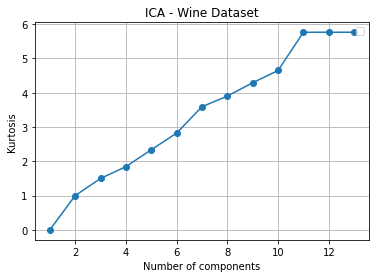

Independent components - Fit times
1 2 3 4 5 6 7 8 9 10 11 12 13
[0.012312, 0.010509, 0.010526, 0.048807, 0.027419, 0.036013, 0.045101, 0.073731, 0.080789, 0.085612, 0.07848, 0.082025, 0.090455]


In [558]:
print('ICA - Wine Dataset')
ica(X=X_std, Y=Y, random_seed=random_seed, no_features=11, ds_name='Wine Dataset')

# ICA with K means - Wine Dataset

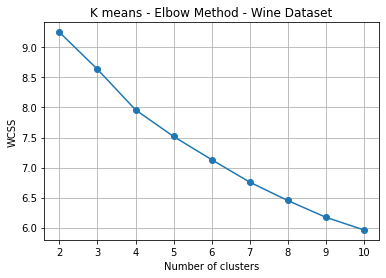

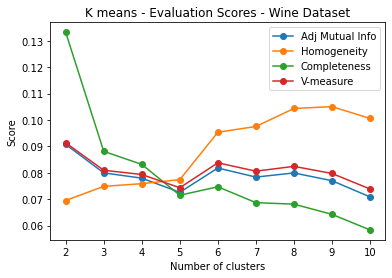

In [559]:
# Choosing n_components = 10 the elbow
ica1 = FastICA(n_components=10, random_state=random_seed)
ica1.fit(X_std)
X_reduced = ica1.fit_transform(X_std)

kmeans(X=X_reduced, Y=Y, random_seed=random_seed, ds_name='Wine Dataset')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  after removing the cwd from sys.path.


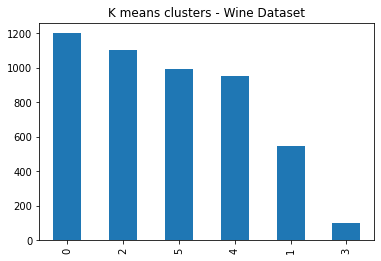

In [560]:
# Choosing k=6 appx from elbow and score peak
kmeans1 = KMeans(n_clusters=6, init='k-means++', random_state=random_seed)
kmeans1.fit(X_reduced)
labels_pred_k = pd.DataFrame(data = kmeans1.labels_, columns=['Cluster labels'])
labels_pred_k['Cluster labels'].value_counts().plot('bar')
plt.title('K means clusters - Wine Dataset')
plt.show()

# ICA with Neural Networks - Wine Dataset 

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Hidden layers**************
   Hidden layer sizes  train score  validation score
0                   2     0.473201          0.452041
1                   4     0.504084          0.475510
2                   6     0.468096          0.452041
3                   8     0.530117          0.507143
4                  10     0.526034          0.506122
hidden_layer_sizes:  [2, 4, 6, 8, 10]
train_score:  [0.47320061255742724, 0.5040837161817253, 0.46809596733027053, 0.5301174068402246, 0.5260336906584993]
test_score:  [0.4520408163265306, 0.47551020408163264, 0.4520408163265306, 0.5071428571428571, 0.5061224489795918]


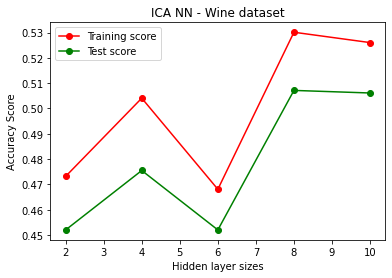

In [561]:
NN(X=X_reduced, Y=Y, plt_title='ICA NN - Wine dataset', random_seed=random_seed)

# ICA K means - NN - Wine 

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Hidden layers**************
   Hidden layer sizes  train score  validation score
0                   2     0.480092          0.483673
1                   4     0.480092          0.483673
2                   6     0.480092          0.483673
3                   8     0.449974          0.443878
4                  10     0.449974          0.443878
hidden_layer_sizes:  [2, 4, 6, 8, 10]
train_score:  [0.48009188361408883, 0.48009188361408883, 0.48009188361408883, 0.4499744767738642, 0.4499744767738642]
test_score:  [0.48367346938775513, 0.48367346938775513, 0.48367346938775513, 0.44387755102040816, 0.44387755102040816]


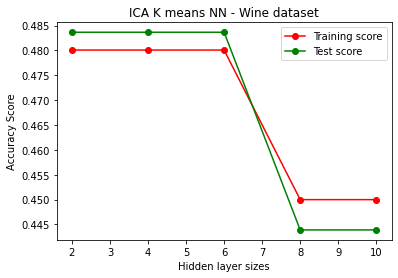

In [562]:
# Using labels from k means as feature X
NN(X=labels_pred_k, Y=Y, plt_title='ICA K means NN - Wine dataset', random_seed=random_seed)

# ICA with EM - Wine Dataset

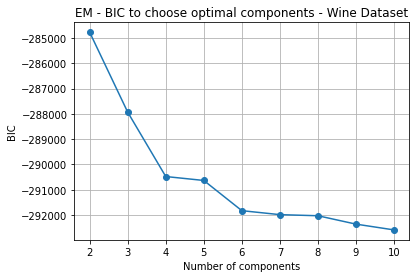

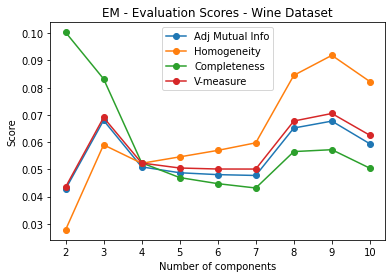

In [563]:
em(X=X_reduced, Y=Y, random_seed=random_seed, ds_name='Wine Dataset')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  after removing the cwd from sys.path.


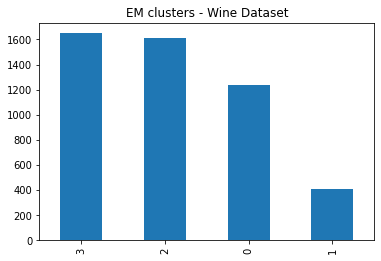

In [564]:
#Choosing components = 4 where BIC lowers significantly
gmm1 = GMM(n_components=4, random_state=random_seed)
gmm1.fit(X_reduced)
labels_pred_em = pd.DataFrame(data = gmm1.predict(X_reduced), columns=['Cluster labels'])
labels_pred_em['Cluster labels'].value_counts().plot('bar')
plt.title('EM clusters - Wine Dataset')
plt.show()

# ICA EM - NN - Wine

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Hidden layers**************
   Hidden layer sizes  train score  validation score
0                   2     0.470393          0.469388
1                   4     0.449974          0.443878
2                   6     0.470393          0.469388
3                   8     0.470393          0.469388
4                  10     0.470393          0.469388
hidden_layer_sizes:  [2, 4, 6, 8, 10]
train_score:  [0.47039305768249107, 0.4499744767738642, 0.47039305768249107, 0.47039305768249107, 0.47039305768249107]
test_score:  [0.46938775510204084, 0.44387755102040816, 0.46938775510204084, 0.46938775510204084, 0.46938775510204084]


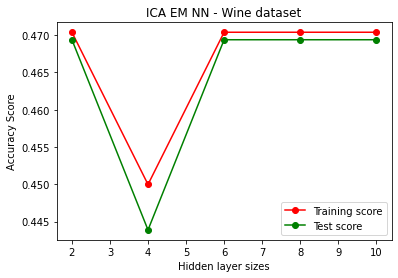

In [565]:
# Using labels from EM as feature X
NN(X=labels_pred_em, Y=Y, plt_title='ICA EM NN - Wine dataset', random_seed=random_seed)

# ***Seeds Dataset***

# Load Seeds data

In [566]:
random_seed = 1
seeds = 'Seed_Data.csv'
df2 = pd.read_csv(seeds)
X2 = df2.iloc[:, :-1]
Y2 = df2.iloc[:, -1]
# Standardize
X_std2 = StandardScaler().fit_transform(X2)
X_std2 = pd.DataFrame(data=X_std2, columns=X2.columns)
X_std2.shape
# X, X_test, Y, Y_test = train_test_split(data_X, data_y, train_size=0.8, random_state=random_seed)

(210, 7)

# ICA - Seeds dataset

/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:469: UserWarning: n_components is too large: it will be set to 7
  % n_components
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:469: UserWarning: n_components is too large: it will be set to 7
  % n_components
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
No handles with labels found to put in legend.


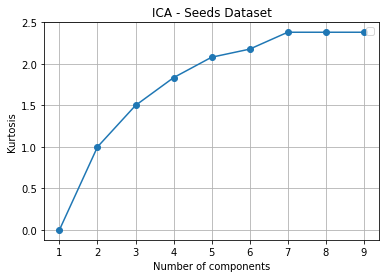

Independent components - Fit times
1 2 3 4 5 6 7 8 9
[0.004353, 0.003905, 0.004423, 0.009007, 0.009438, 0.008695, 0.104499, 0.112341, 0.102958]


In [567]:
ica(X=X_std2, Y=Y2, random_seed=random_seed, no_features=X_std2.shape[1], ds_name='Seeds Dataset')

# ICA with K means - Seeds Dataset

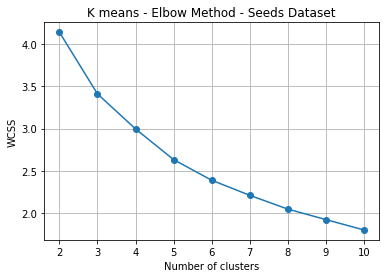

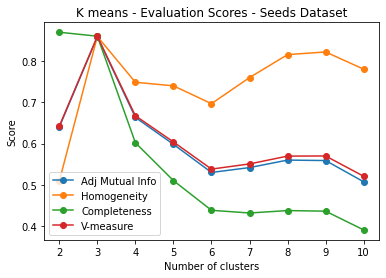

In [568]:
# Choosing n_components = 5 the elbow
ica2 = FastICA(n_components=5, random_state=random_seed)
ica2.fit(X_std2)
X_reduced2 = ica2.fit_transform(X_std2)

kmeans(X=X_reduced2, Y=Y2, random_seed=random_seed, ds_name='Seeds Dataset')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  after removing the cwd from sys.path.


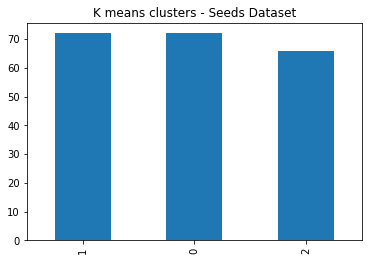

In [569]:
# Choosing k=3 appx from elbow and score peak
kmeans2 = KMeans(n_clusters=3, init='k-means++', random_state=random_seed)
kmeans2.fit(X_reduced2)
labels_pred = pd.DataFrame(data = kmeans2.labels_, columns=['Cluster labels'])
labels_pred['Cluster labels'].value_counts().plot('bar')
plt.title('K means clusters - Seeds Dataset')
plt.show()

# ICA with EM - Seeds Dataset

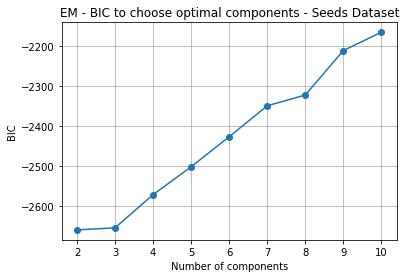

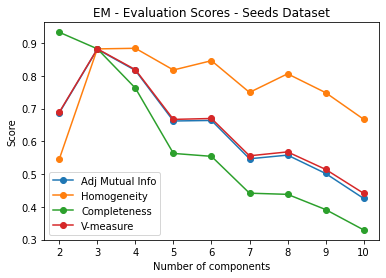

In [570]:
em(X=X_reduced2, Y=Y2, random_seed=random_seed, ds_name='Seeds Dataset')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  after removing the cwd from sys.path.


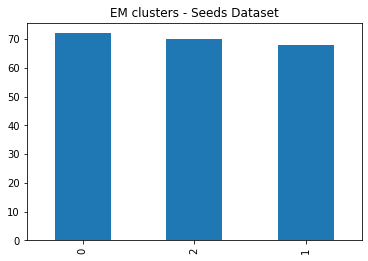

In [571]:
#Choosing components = 3 where BIC lowers significantly
gmm2 = GMM(n_components=3, random_state=random_seed)
gmm2.fit(X_reduced2)
labels_pred = pd.DataFrame(data = gmm2.predict(X_reduced2), columns=['Cluster labels'])
labels_pred['Cluster labels'].value_counts().plot('bar')
plt.title('EM clusters - Seeds Dataset')
plt.show()